In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
import scipy
import os

In [2]:
# project files

from utils.variables import pack, unpack
from utils.display import table
from utils.files import save, load
from utils.hash import digest
from utils.rounding import progressive_soft_round_loop, RoundApprox

from model.fit_options import fit_options
from model.game import game
from model.data import download_data
from model.rp import compute_rp, make_precomputed_columns
from model.initial_guess import make_initial_guess


In [3]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [4]:
refresh_rp_file = True

if (refresh_rp_file):

    data = download_data()
    data.to_pickle(fit_options.data_file)
    
else:
    
    data = pd.read_pickle(fit_options.data_file)


In [5]:
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.000000,7771.00000,7771.000000,7771.000000,7771.000000,7771.000000,7771.0,7771.000000,7771.000000,7771.000000,7771.000000
mean,11.713422,663.504182,1.581135,663.510616,0.006434,3864.869386,3702.560196,12.517694,28.021876,38.874276,108.521554,1.052698,0.987675,0.994451,0.997529,1.00960,0.207487,36.214361,56.775576,148.531141,1.0,0.108352,4.518852,0.985299,1.031560
std,7.755388,442.393993,1.059953,442.407173,0.577314,976.068160,1042.780251,3.542903,2.596460,8.685571,16.133481,0.320600,0.058436,0.044974,0.118567,0.11866,0.045806,40.553191,28.692011,62.733171,0.0,0.612689,24.710514,0.040890,0.073808
min,1.000000,245.000000,1.000000,245.000000,-15.000000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.80000,0.130000,5.940000,25.000000,90.000000,1.0,0.000000,0.000000,0.790000,1.000000
25%,6.000000,364.000000,1.000000,365.000000,0.000000,3000.000000,2836.200000,10.000000,26.000000,33.000000,98.000000,0.820000,1.000000,1.000000,1.000000,1.00000,0.180000,14.120000,36.000000,101.000000,1.0,0.000000,0.000000,1.000000,1.000000
50%,10.000000,509.000000,1.000000,509.000000,0.000000,3800.000000,3678.400000,12.000000,28.000000,37.000000,103.000000,0.970000,1.000000,1.000000,1.000000,1.00000,0.200000,20.750000,47.000000,121.000000,1.0,0.000000,0.000000,1.000000,1.000000
75%,15.000000,784.000000,2.000000,784.000000,0.000000,4500.000000,4382.780000,15.000000,30.000000,43.000000,115.000000,1.260000,1.000000,1.000000,1.000000,1.00000,0.230000,48.080000,68.000000,202.000000,1.0,0.000000,0.000000,1.000000,1.000000
max,45.000000,3493.000000,6.000000,3495.000000,5.000000,6300.000000,6916.140000,24.000000,35.000000,83.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.20000,0.420000,414.120000,243.000000,511.000000,1.0,8.000000,342.000000,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.0,0.0,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.9,1.00,1.0,0.8,0.26,22.75,538.35,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,531.0,0.0,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.0,1.00,1.0,1.0,0.26,22.75,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.0,0.0,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.0,1.00,1.2,1.0,0.26,22.75,530.61,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arbok,9.0,582.0,Relaxed,1.0,,582.0,0.0,Relaxed,ArbokRelaxed91,Energy Recovery,EXP Gains,3700.0,3640.80,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,0.98,1.0,1.08,1.0,1.0,0.26,22.75,538.89,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arbok,9.0,489.0,Timid,1.0,,489.0,0.0,Timid,ArbokTimid91,EXP Gains,Speed of Help,3700.0,4004.88,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,0.89,1.1,1.00,1.0,1.0,0.26,22.75,538.45,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0


In [6]:
fit_options.rounding.final_rp = RoundApprox.Pass
fit_options.rounding.bonus = RoundApprox.Exact
fit_options.rounding.period = RoundApprox.Pass
fit_options.rounding.components = RoundApprox.Pass


In [7]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(*make_initial_guess())


In [8]:
# Compute per sample information about help time, nature, subskills etc
computed = make_precomputed_columns(data)

# Do we match the sheet? Yes
(computed.helps_per_hour - data["Helps per hour"]).describe()

count    7.771000e+03
mean     2.405888e-17
std      5.882131e-17
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.440892e-16
Name: Helps per hour, dtype: float64

In [9]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)

def residual(x):
    return data["RP"].to_numpy() - RP(x)

count    7771.000000
mean       -0.944795
std         1.227910
min       -11.000000
25%        -1.000000
50%        -1.000000
75%         0.000000
max        17.000000
Name: RP, dtype: float64

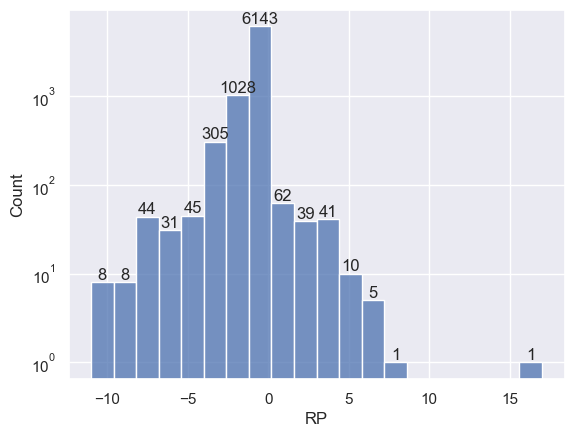

In [10]:
# what is the quality of the initial guess?

r= data["RP"] - np.round(RP(x0))
pd.Series(r).describe()

# _ = plt.figure()
# g = sns.histplot(x=np.clip(np.abs(r), 1e-1,1e3), log_scale=True, bins=20)
# g.axes.set_yscale('log')
# _ = g.bar_label(g.containers[1], labels= [str(v) if v else '' for v in g.containers[1].datavalues])

_ = plt.figure()
g = sns.histplot(x=r, bins=20)
_ = g.axes.set_yscale('log')
_ = g.bar_label(g.containers[1], labels= [str(v) if v else '' for v in g.containers[1].datavalues])

In [11]:
cache_fit = False

# least_squares gives a deterministic result that depends on x0, the data, and the optimizer options
# hash the data as well as x0 to decide if we reuse last fit

filename = fit_options.get_result_file(digest(data, x0))

if cache_fit and os.path.isfile(filename):
    opt = load(filename)
    print("Loaded from cache")

else:

    opt = progressive_soft_round_loop( x0,
            lambda x: scipy.optimize.least_squares(residual, x, **fit_options.least_squares_kwargs)
         )

    # save results and remove some stuff we don't need to save.
    if 'jac' in opt: del opt.jac
    if 'active_mask' in opt: del opt.active_mask
    if 'fun' in opt: del opt.fun
    if 'final_simplex' in opt: del opt.final_simplex

    save(filename, opt)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.8940e+03                                    6.48e+06    
       1              4         1.3245e+03      7.57e+03       5.12e-01       2.60e+05    
       2              6         1.2872e+03      3.73e+01       2.56e-01       1.34e+03    
       3              8         1.2850e+03      2.19e+00       1.28e-01       1.47e+02    
       4             10         1.2844e+03      6.62e-01       6.40e-02       3.55e+01    
       5             12         1.2841e+03      2.23e-01       3.20e-02       8.55e+00    
       6             13         1.2839e+03      2.29e-01       6.40e-02       3.48e+01    
       7             16         1.2839e+03      8.31e-03       8.00e-03       7.52e-01    
       8             17         1.2839e+03      4.06e-03       1.60e-02       7.88e-01    
       9             21         1.2839e+03      5.23e-08       5.00e-04       7.04e-03    

In [12]:
opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 5.625e-01  5.436e-01 ...  3.747e-01  3.691e-01]
       cost: 1283.8894778888819
       grad: [ 1.364e-05  3.493e-06 ...  0.000e+00  0.000e+00]
 optimality: 0.0070385140425059944
       nfev: 21
       njev: 10

count    7771.000000
mean       -0.000901
std         0.576122
min        -4.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        16.000000
Name: RP, dtype: float64

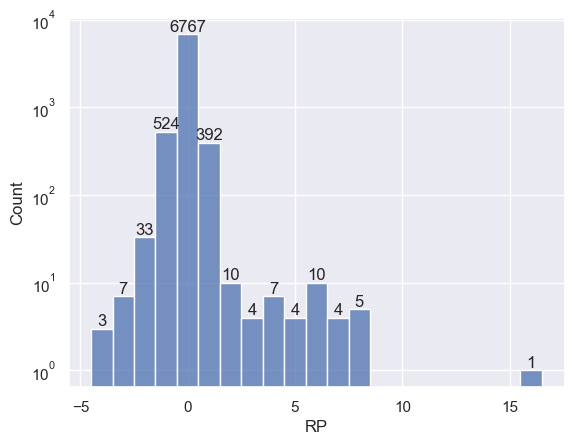

In [13]:
r_opt = data["RP"] - np.round(RP(opt.x))
pd.Series(r_opt).describe()

# _ = plt.figure()
# g = sns.histplot(x=np.clip(np.abs(r_opt), 1e-1,1e3), log_scale=True, bins=20)
# g.axes.set_yscale('log')
# _ = g.bar_label(g.containers[1], labels= [str(v) if v else '' for v in g.containers[1].datavalues])

_ = plt.figure()
g = sns.histplot(x=r_opt, discrete=1)
_ = g.axes.set_yscale('log')
_ = g.bar_label(g.containers[1], labels= [str(v) if v else '' for v in g.containers[1].datavalues])


In [14]:
sol = unpack(opt.x, unpack_info)
table(sol)

Pokemons ing fractions,[0.25624876 0.254359 0.26546841 ... 0.1797384 0.20047619 0.215708 ]
Pokemons skill products,[16.70673734 16.71023463 18.47330063 ... 44.69610296 12.7886009 15.52088829]
Charge Strength S,[0.74639262 0.32260296]
Charge Strength M,[0.74532453 0.32270741]
Ingredient Magnet S,[0.74556945 0.322626 ]
Cooking Power-Up S,[0.74455211 0.32313657]
Extra Helpful S,[0.74602048 0.32243116]
Charge Energy S,[0.74799188 0.32202237]
Energizing Cheer S,[0.74656369 0.32203221]
Energy for Everyone S,[0.74571705 0.32271079]
Dream Shard Magnet S,[0.74538074 0.32240268]


In [15]:
# Format ing% and skillProduct pretty

res = pd.DataFrame({"Pokemon":game.data.pokedex["Pokemon"], "ing%": sol["Pokemons ing fractions"]*100.0, "skill% * skillValue": sol["Pokemons skill products"] })
res.set_index("Pokemon")

,ing%,skill% * skillValue
Pokemon,,
Bulbasaur,25.624876,16.706737
Ivysaur,25.435900,16.710235
Venusaur,26.546841,18.473301
Charmander,20.037574,9.674276
Charmeleon,22.666699,14.046484
Charizard,22.348197,14.102531
Squirtle,26.996045,17.628824
Wartortle,27.032015,17.588451
Blastoise,27.427831,18.456620


In [16]:
# Format main skill growth per level 

growth_display = {}
levels = np.array(list(range(2,7)))
growth_display["Level"] = levels

for record in game.data.mainskills.to_dict(orient='records') :
    
    skillname = record["Skill"]
    params = sol[skillname]
    growth_display[skillname] = params[0]*np.exp(params[1]*levels)
    
df = pd.DataFrame(growth_display)
df.set_index("Level")


,Charge Strength S,Charge Strength M,Ingredient Magnet S,Cooking Power-Up S,Extra Helpful S,Charge Energy S,Energizing Cheer S,Energy for Everyone S,Dream Shard Magnet S,Metronome
Level,,,,,,,,,,
2,1.422908,1.421168,1.421404,1.420915,1.421710,1.424302,1.421610,1.421926,1.420410,1.421885
3,1.964633,1.962436,1.962602,1.962928,1.962641,1.965416,1.961721,1.963490,1.960791,1.963507
4,2.712602,2.709852,2.709860,2.711695,2.709387,2.712108,2.707036,2.711316,2.706755,2.711442
5,3.745336,3.741930,3.741636,3.746082,3.740254,3.742481,3.735519,3.743964,3.736515,3.744280
6,5.171249,5.167086,5.166260,5.175040,5.163346,5.164308,5.154751,5.169912,5.158036,5.170544


In [17]:
# What are the worst points?

df = data[["Pokemon","ID","Level","MS lvl","NatureP","NatureN","Sub Skill 1","Sub Skill 2","RP"]].copy()

df["fit"] = RP(opt.x)
df["error"] = data["RP"] - np.round(RP(opt.x))
df["error2"] = df["error"]**2

df = df.sort_values("error2", ascending = False).reset_index(drop=True)
df.head(100)

,Pokemon,ID,Level,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
0,Glaceon,GlaceonNeutral276Skill Level Up MHelping Speed M,27.0,6.0,-,-,Skill Level Up M,Helping Speed M,2485.0,2469.291927,16.0,256.0
1,Raichu,RaichuNaughty313Helping Speed SInventory Up S,31.0,3.0,Speed of Help,Main Skill Chance,Helping Speed S,Inventory Up S,1663.0,1654.708120,8.0,64.0
2,Togekiss,TogekissGentle103Skill Trigger M,10.0,3.0,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1273.548159,8.0,64.0
3,Sylveon,SylveonRelaxed102Helping Bonus,10.0,2.0,Energy Recovery,EXP Gains,Helping Bonus,,1023.0,1015.469743,8.0,64.0
4,Charizard,CharizardNeutral273Berry Finding SHelping Speed M,27.0,3.0,-,-,Berry Finding S,Helping Speed M,1528.0,1520.026566,8.0,64.0
5,Charizard,CharizardRash273Helping BonusHelping Speed M,27.0,3.0,Ingredient Finding,Main Skill Chance,Helping Bonus,Helping Speed M,1440.0,1432.102815,8.0,64.0
6,Typhlosion,TyphlosionCareful273Berry Finding SHelping Spe...,27.0,3.0,Main Skill Chance,Ingredient Finding,Berry Finding S,Helping Speed M,1761.0,1754.181434,7.0,49.0
7,Charizard,CharizardNeutral273Inventory Up MHelping Speed M,27.0,3.0,-,-,Inventory Up M,Helping Speed M,1299.0,1292.103186,7.0,49.0
8,Charizard,CharizardMild276Helping Speed MSkill Level Up M,27.0,6.0,Ingredient Finding,Energy Recovery,Helping Speed M,Skill Level Up M,1514.0,1506.867126,7.0,49.0
9,Charizard,CharizardMild276Skill Level Up MHelping Speed M,27.0,6.0,Ingredient Finding,Energy Recovery,Skill Level Up M,Helping Speed M,1514.0,1506.867126,7.0,49.0
